# Dog Breed Identification with Feature Extractors

In this third and final Notebook, I will use a different approach of transfer learning. Instead of using just a single CNN model to determine the dog breeds, I am going to use more than one pre-trained CNN models as feature extractors. Let's see how this goes...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

from functools import partial

### Load and prepare data

In [2]:
from google.colab import drive
# Accessing My Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
INPUT_PATH = "drive/My Drive/Dog Breed Identification/"
TRAIN_ROOT_PATH = INPUT_PATH + "train/"
TEST_ROOT_PATH = INPUT_PATH + "test/"

In [4]:
# read the labels dataset
labels = pd.read_csv(INPUT_PATH + "labels.csv")
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [5]:
labels.shape

(10222, 2)

In [6]:
# training settings
BATCH_SIZE = 128
DATASET_SIZE = len(labels["breed"])
NUM_CLASSES = labels["breed"].nunique()

In [7]:
# tf.data.Dataset settings
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [8]:
# Map dog breeds to numbers
label_to_num = dict(zip(sorted(list(labels["breed"].unique())),
                        range(NUM_CLASSES)))

In [9]:
x_train = labels["id"]
y_train = labels["breed"]

In [10]:
def get_image_path(image_id, extension=".jpg"):
    """
    Given the id of an image return its directory path
    """
    return TRAIN_ROOT_PATH + image_id + extension

def load_and_decode_image(path, channels=3):
    """
    Read a JPEG-encoded image from path and decode it to a uint8 tensor
    """
    image = tf.io.read_file(path)
    return tf.image.decode_jpeg(image, channels=channels)

def get_label_num(label_name):
    """
    Represent labels with numbers 
    """
    return label_to_num.get(label_name)

def get_label_from_num(num):
    """
    Get label from numerical representation 
    """
    return list(label_to_num.keys())[list(label_to_num.values()).index(num)]

In [11]:
def get_pair_ds(images, labels):
    """
    Load images and labels to datasets
    """
    path_ds = tf.data.Dataset.from_tensor_slices(list(map(get_image_path, images.values)))
    image_ds = path_ds.map(load_and_decode_image, num_parallel_calls=AUTOTUNE)
    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(list(map(get_label_num, labels.values)), tf.int64))
    return image_ds, label_ds

def apply_ds(image_ds, label_ds):
    """
    Combine image and label datasets
    """
    ds = tf.data.Dataset.zip((image_ds, label_ds))
    return ds

# load the training images to datasets
train_ds = apply_ds(*get_pair_ds(x_train, y_train))

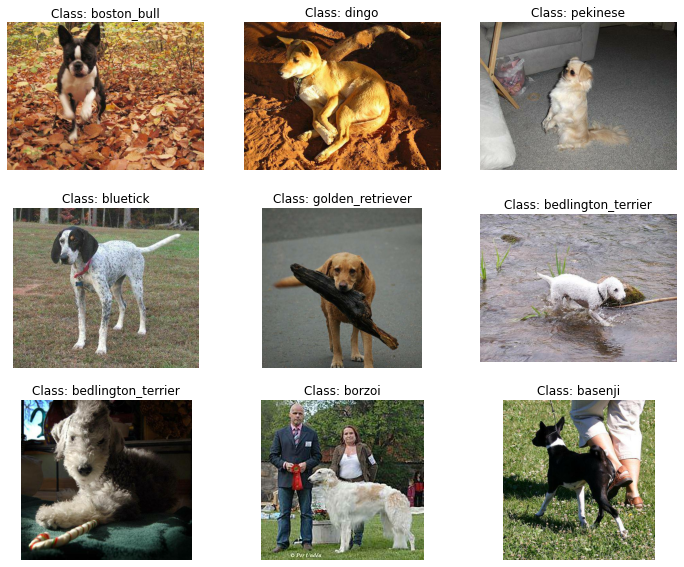

In [12]:
# plot the first 9 images of the training dataset
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_ds.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(get_label_from_num(label)))
    plt.axis("off")

plt.show()

In [13]:
IMG_SIZE = 331

def preprocess(image, label):
    resized_image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return resized_image, label

In [14]:
train_set = train_ds.map(preprocess).batch(BATCH_SIZE)

### Data augmentation


In [15]:
data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Let's repeatedly apply these layers to the same image and see the result.

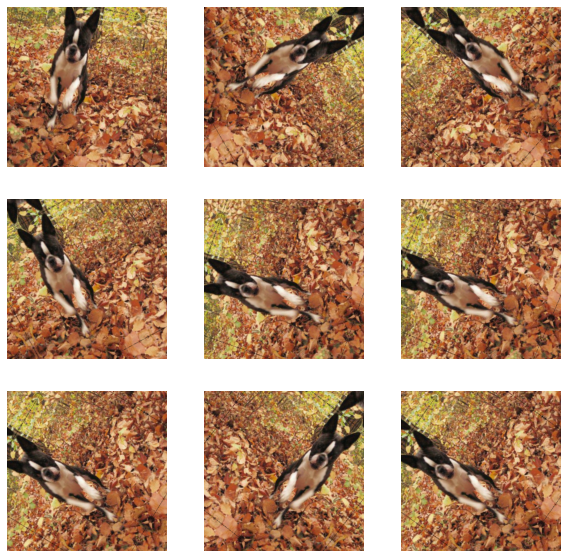

In [16]:
for image, _ in train_set.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image/255, 0))
    plt.imshow(augmented_image[0])
    plt.axis('off');

### Create feature extractors to get features from data

To create a feature extractor basically what we have to do is remove the fully connected layers from the pre-trained model. This way we will have many more features that will help us determine the breed of the dogs.

In [17]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE) + (3,)

def feature_extractor(trained_model, preprocessor, data, input_size=IMG_SHAPE):
    inputs = keras.Input(shape=input_size)
    x = keras.layers.Lambda(preprocessor)(inputs)
    x = data_augmentation(x)
    x = trained_model(weights="imagenet", input_shape=input_size,
                      include_top=False)(x, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    return keras.Model(inputs=inputs, outputs=x)

def extract_features(trained_model, preprocessor, data, input_size=IMG_SHAPE):
    features = feature_extractor(trained_model, preprocessor, data,
                         input_size=IMG_SHAPE).predict(data,
                                                       batch_size=BATCH_SIZE,
                                                       verbose=1)
    print("Feature maps shape: {}".format(features.shape))
    return features

### Feature Extraction

Let's create 6 feature extractors using different pre-trained CNN models. Specifically, I will use:
 * InceptionV3, 
 * Xception, 
 * NASNetLarge, 
 * InceptionResNetV2, 
 * ResNet152V2, and 
 * DenseNet201


##### Extract features using InceptionV3 as extractor

In [18]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
inception_features = extract_features(InceptionV3,
                                  inception_preprocessor,
                                  train_set)

80/80 [==============================] - 1051s 13s/step
Feature maps shape: (10222, 2048)


##### Extract features using Xception as extractor

In [19]:
from keras.applications.xception import Xception, preprocess_input
xception_preprocessor = preprocess_input
xception_features = extract_features(Xception,
                                 xception_preprocessor,
                                 train_set)

80/80 [==============================] - 100s 1s/step
Feature maps shape: (10222, 2048)


##### Extract features using NASNetLarge as extractor

In [20]:
from keras.applications.nasnet import NASNetLarge, preprocess_input
nasnet_preprocessor = preprocess_input
nasnet_features = extract_features(NASNetLarge,
                               nasnet_preprocessor,
                               train_set)

80/80 [==============================] - 309s 4s/step
Feature maps shape: (10222, 4032)


##### Extract features using InceptionResNetV2 as extractor

In [21]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
inc_resnet_preprocessor = preprocess_input
inc_resnet_features = extract_features(InceptionResNetV2,
                                   inc_resnet_preprocessor,
                                   train_set)

80/80 [==============================] - 126s 2s/step
Feature maps shape: (10222, 1536)


##### Extract features using ResNet152V2 as extractor

In [22]:
from keras.applications.resnet_v2 import ResNet152V2, preprocess_input
resnet_preprocessor = preprocess_input
resnet_features = extract_features(ResNet152V2,
                                   resnet_preprocessor,
                                   train_set)

80/80 [==============================] - 168s 2s/step
Feature maps shape: (10222, 2048)


##### Extract features using DenseNet201 as extractor

In [23]:
from keras.applications.densenet import DenseNet201, preprocess_input
densenet_preprocessor = preprocess_input
densenet_features = extract_features(DenseNet201,
                                   densenet_preprocessor,
                                   train_set)

80/80 [==============================] - 105s 1s/step
Feature maps shape: (10222, 1920)


##### Combine extracted features

Now that I have extracted the features from the original data, I will stack them all together:

In [24]:
train_features = np.concatenate([inception_features,
                                 xception_features,
                                 nasnet_features,
                                 inc_resnet_features,
                                 resnet_features,
                                 densenet_features,], axis=-1)
print('Train feature maps shape', train_features.shape)

Train feature maps shape (10222, 13632)


As we can see now we have 13632 features.

### Prepare labels

In [25]:
y = np.array(list(map(get_label_num, y_train.values)), dtype=np.uint8)

# One-hot encoded
y_ohe = keras.utils.to_categorical(y)

### DNN model

Finally, I will use a simple DNN with one dropout layer and one dense layer, in order to detect patterns in the features I extracted earlier.


##### Create DNN model

In [26]:
# callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint("drive/My Drive/Dog Breed Identification/best_model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=8,
                                                  monitor="val_accuracy")
callbacks = [checkpoint_cb, early_stopping_cb]

In [27]:
dnn = keras.models.Sequential([
    keras.layers.InputLayer(train_features.shape[1:]),
    keras.layers.Dropout(0.8),
    keras.layers.Dense(NUM_CLASSES, activation="softmax")
])

In [28]:
dnn.compile(optimizer=keras.optimizers.Adam(lr=0.0001),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [29]:
dnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 13632)             0         
_________________________________________________________________
dense (Dense)                (None, 120)               1635960   
Total params: 1,635,960
Trainable params: 1,635,960
Non-trainable params: 0
_________________________________________________________________


##### Train the model

In [30]:
history = dnn.fit(train_features, y_ohe,
            batch_size=BATCH_SIZE,
            epochs=60,
            validation_split=0.1,
            callbacks=callbacks)

Epoch 1/60
72/72 [==============================] - 4s 60ms/step - loss: 3.7846 - accuracy: 0.2289 - val_loss: 2.0297 - val_accuracy: 0.8856
Epoch 2/60
72/72 [==============================] - 1s 8ms/step - loss: 1.5382 - accuracy: 0.7645 - val_loss: 0.7376 - val_accuracy: 0.9316
Epoch 3/60
72/72 [==============================] - 1s 8ms/step - loss: 0.7217 - accuracy: 0.8865 - val_loss: 0.4115 - val_accuracy: 0.9423
Epoch 4/60
72/72 [==============================] - 1s 8ms/step - loss: 0.4619 - accuracy: 0.9113 - val_loss: 0.3026 - val_accuracy: 0.9433
Epoch 5/60
72/72 [==============================] - 1s 8ms/step - loss: 0.3590 - accuracy: 0.9258 - val_loss: 0.2516 - val_accuracy: 0.9472
Epoch 6/60
72/72 [==============================] - 1s 8ms/step - loss: 0.2971 - accuracy: 0.9311 - val_loss: 0.2253 - val_accuracy: 0.9472
Epoch 7/60
72/72 [==============================] - 1s 8ms/step - loss: 0.2571 - accuracy: 0.9409 - val_loss: 0.2089 - val_accuracy: 0.9472
Epoch 8/60
72/72 [=

### Predictions

In [31]:
# load the best model
best_model = keras.models.load_model("drive/My Drive/Dog Breed Identification/best_model.h5")

##### Prepare test data

In [32]:
# read the submission csv
submission_df = pd.read_csv(INPUT_PATH + "sample_submission.csv")
submission_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333

In [33]:
submission_df.shape

(10357, 121)

In [34]:
def get_image_path_test(image_id, extension=".jpg"):
    """
    Given the id of an image return its directory path
    """
    return TEST_ROOT_PATH + image_id + extension

def preprocess_test(image, img_size=IMG_SIZE):
    resized_image = tf.image.resize(image, [img_size, img_size])
    return resized_image

In [35]:
test_ids = submission_df['id']

# load and decode test images
path_ds = tf.data.Dataset.from_tensor_slices(list(map(get_image_path_test, test_ids.values)))
test_ds = path_ds.map(load_and_decode_image, num_parallel_calls=AUTOTUNE)

# preprocess, batch, and prefetch the test dataset
test_set = test_ds.map(preprocess_test).batch(BATCH_SIZE)

##### Extract test data features

In [36]:
inception_features = extract_features(InceptionV3, inception_preprocessor, test_set)
xception_features = extract_features(Xception, xception_preprocessor, test_set)
nasnet_features = extract_features(NASNetLarge, nasnet_preprocessor, test_set)
inc_resnet_features = extract_features(InceptionResNetV2, inc_resnet_preprocessor, test_set)
resnet_features = extract_features(ResNet152V2,resnet_preprocessor, test_set)
densenet_features = extract_features(DenseNet201, densenet_preprocessor, test_set)

81/81 [==============================] - 1423s 18s/step
Feature maps shape: (10357, 2048)
81/81 [==============================] - 103s 1s/step
Feature maps shape: (10357, 2048)
81/81 [==============================] - 314s 4s/step
Feature maps shape: (10357, 4032)
81/81 [==============================] - 129s 2s/step
Feature maps shape: (10357, 1536)
81/81 [==============================] - 172s 2s/step
Feature maps shape: (10357, 2048)
81/81 [==============================] - 107s 1s/step
Feature maps shape: (10357, 1920)


In [37]:
test_features = np.concatenate([inception_features,
                                xception_features,
                                nasnet_features,
                                inc_resnet_features,
                                resnet_features,
                                densenet_features], axis=-1)
print('Test feature maps shape', test_features.shape)

Test feature maps shape (10357, 13632)


##### Make predictions and create submission file

In [38]:
y_pred = best_model.predict(test_features, batch_size=BATCH_SIZE)

In [39]:
y_pred.shape

(10357, 120)

In [40]:
for breed in labels['breed'].unique():
    submission_df[breed] = y_pred[:, get_label_num(breed)]

In [41]:
submission_df.to_csv('drive/My Drive/Dog Breed Identification/feature_extractors.csv', index=None)

The above submission gives a score of 0.17265 in the public leaderboard of Kaggle, which would be about the position 188 (top 15%).

### References


*   https://www.kaggle.com/wakamezake/tf-keras-dog-breed-identification
*   https://www.tensorflow.org/tutorials/images/transfer_learning#use_data_augmentation
*   https://www.kaggle.com/phylake1337/0-18-loss-simple-feature-extractors
*   Aurélien Géron - "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow", O'Reilly Media
